<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

In [2]:
#loading the data into dataframe
project_data = pd.read_csv('train_data.csv', nrows=50000)
resource_data = pd.read_csv('resources.csv')

In [3]:
#preprocessing project_grade_category
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()

#preprocessing project_subject_categories
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()

#preprocessing teacher_prefix
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.nan,'mrs')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()

#preprocessing project_subject_subcategories
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

#preprocessing school_state
project_data['school_state'] = project_data['school_state'].str.lower()


In [4]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
#defining stopwords
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [6]:
# function to remove stopwords and preprocessing text feature
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [7]:
#preprocessing project tites
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 14285.25it/s]


In [8]:
#creating new column essay by concatenating essay-1 to essay 4
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [9]:
#preprocessing project essay
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:24<00:00, 592.60it/s]


In [10]:
#merging data to obtain price for each project from resource data dataframe

price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [11]:
#standerdise price and creating new column called nrm_price
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['nrm_price']=scaler.transform(project_data['price'].values.reshape(-1, 1))

In [12]:
#removing unused column from df
project_data=project_data.drop(['project_essay_1','Unnamed: 0','teacher_id','project_submitted_datetime','project_essay_2','project_essay_3','project_essay_4'], axis=1)

In [13]:
#split data on the basis of label using x,y

y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

In [14]:
#splitting the data into train,test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [15]:
vectorizer_essay = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_essay.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer_essay.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer_essay.transform(X_test['essay'].values)

vectorizer_title = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_title.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_bow = vectorizer_title.transform(X_train['project_title'].values)
X_cv_project_title_bow = vectorizer_title.transform(X_cv['project_title'].values)
X_test_project_title_bow = vectorizer_title.transform(X_test['project_title'].values)


vectorizer_state = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_state.fit(X_train['school_state'].values) # fit has to happen only on train data


# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_state.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer_state.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer_state.transform(X_test['school_state'].values)

vectorizer_teacher = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_teacher.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer_teacher.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_teacher.transform(X_test['teacher_prefix'].values)

vectorizer_grade_category = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_grade_category.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_grade_category.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer_grade_category.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer_grade_category.transform(X_test['project_grade_category'].values)

vectorizer_subject_category = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_subject_category.fit(X_train['project_subject_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subject_categories_ohe = vectorizer_subject_category.transform(X_train['project_subject_categories'].values)
X_cv_subject_categories_ohe = vectorizer_subject_category.transform(X_cv['project_subject_categories'].values)
X_test_subject_categories_ohe = vectorizer_subject_category.transform(X_test['project_subject_categories'].values)

vectorizer_subject_sub_category = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_subject_sub_category.fit(X_train['project_subject_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subject_subcategories_ohe = vectorizer_subject_sub_category.transform(X_train['project_subject_subcategories'].values)
X_cv_subject_subcategories_ohe = vectorizer_subject_sub_category.transform(X_cv['project_subject_subcategories'].values)
X_test_subject_subcategories_ohe = vectorizer_subject_sub_category.transform(X_test['project_subject_subcategories'].values)

In [16]:
#using tfidf for text feature to make set 2

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)

vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_tfidf = vectorizer.transform(X_train['project_title'].values)
X_cv_project_title_tfidf= vectorizer.transform(X_cv['project_title'].values)
X_test_project_title_tfidf = vectorizer.transform(X_test['project_title'].values)

In [17]:
#standerise numerical data using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler_price = MinMaxScaler()

scaler_price.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = scaler_price.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = scaler_price.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = scaler_price.transform(X_test['price'].values.reshape(-1,1))

scaler_quantity = MinMaxScaler()
scaler_quantity.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = scaler_quantity.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = scaler_quantity.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = scaler_quantity.transform(X_test['quantity'].values.reshape(-1,1))

scaler_previous_proj = MinMaxScaler()
scaler_previous_proj.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_projects = scaler_previous_proj.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prev_projects = scaler_previous_proj.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_projects= scaler_previous_proj.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


In [18]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039

#Concatinating all the features for set 1
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_project_title_bow, X_train_prev_projects,X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_subject_categories_ohe,X_train_subject_subcategories_ohe,X_train_price_norm,X_train_quantity_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow,X_cv_project_title_bow, X_cv_state_ohe,X_cv_prev_projects, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_subject_categories_ohe,X_cv_subject_subcategories_ohe, X_cv_price_norm,X_cv_quantity_norm)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_project_title_bow, X_test_state_ohe,X_test_prev_projects, X_test_teacher_ohe, X_test_grade_ohe,X_test_subject_categories_ohe,X_test_subject_subcategories_ohe, X_test_price_norm,X_test_quantity_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 7903) (22445,)
(11055, 7903) (11055,)
(16500, 7903) (16500,)


In [19]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.03it/s]


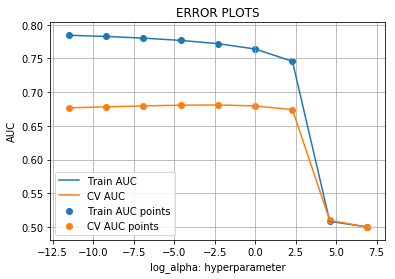

In [20]:
#Hyper parameter Tuning
import math
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

#creating empty array to store train_auc, cv_auc, log_alpha
train_auc = []
cv_auc = []
log_alpha = []

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]
for i in tqdm(alpha):
    log_alpha.append(math.log(i))
    neigh = MultinomialNB(alpha=i, class_prior=[0.5,0.5], fit_prior=True)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 4327.37it/s]


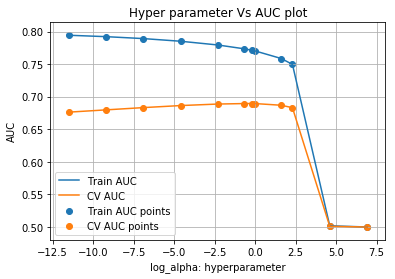

In [21]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1, 5,10,  100,  1000]
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1,5, 10,  100,  1000]}

#applying multinomial naive bayes for above range of alpha
neigh = MultinomialNB(alpha=parameters,class_prior=None, fit_prior=True)
clf = GridSearchCV(neigh, parameters, cv= 10, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)


log_alpha=[]
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

for i in tqdm(alpha):
    log_alpha.append(math.log(i))

plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()


In [24]:
best_alpha=clf.best_params_
print(best_alpha)

{'alpha': 0.8}


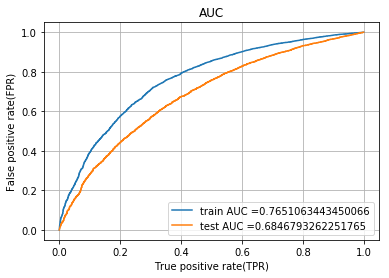

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=0.8, class_prior=[0.5,0.5], fit_prior=True)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True positive rate(TPR)")
plt.ylabel("False positive rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [25]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [26]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.4994475517681949 for threshold 0.287
Train confusion matrix
[[ 2398  1065]
 [ 5291 13691]]
Test confusion matrix
[[1453 1093]
 [4239 9715]]


In [27]:
#Concatinating all the features for set 1
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,X_train_project_title_tfidf, X_train_prev_projects,X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_subject_categories_ohe,X_train_subject_subcategories_ohe,X_train_price_norm,X_train_quantity_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf,X_cv_project_title_tfidf, X_cv_state_ohe,X_cv_prev_projects, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_subject_categories_ohe,X_cv_subject_subcategories_ohe, X_cv_price_norm,X_cv_quantity_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_project_title_tfidf, X_test_state_ohe,X_test_prev_projects, X_test_teacher_ohe, X_test_grade_ohe,X_test_subject_categories_ohe,X_test_subject_subcategories_ohe, X_test_price_norm,X_test_quantity_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 10675) (22445,)
(11055, 10675) (11055,)
(16500, 10675) (16500,)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.37it/s]


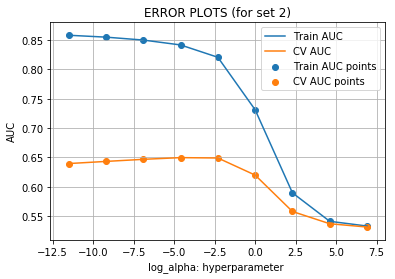

In [30]:
import math
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
log_alpha = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]
for i in tqdm(alpha):
    log_alpha.append(math.log(i))
    neigh = MultinomialNB(alpha=i, class_prior=[0.5,0.5], fit_prior=True)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cr)

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(log_alpha, train_auc, label='Train AUC')
plt.plot(log_alpha, cv_auc, label='CV AUC')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log_alpha: hyperparameter ")
plt.ylabel("AUC")
plt.title("ERROR PLOTS (for set 2)")
plt.grid()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1411.11it/s]


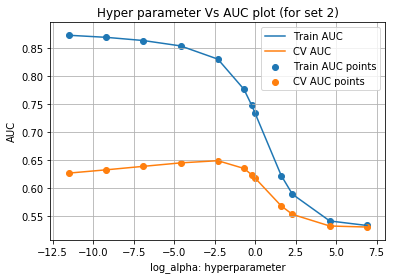

In [31]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1, 5,10,  100,  1000]
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1,0.5,0.8, 1,5, 10,  100,  1000]}
neigh = MultinomialNB(alpha=parameters,class_prior=None, fit_prior=True)
clf = GridSearchCV(neigh, parameters, cv= 10, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)


log_alpha=[]
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

for i in tqdm(alpha):
    log_alpha.append(math.log(i))

plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log_alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot (for set 2)")
plt.grid()
plt.show()

In [32]:
best_alpha_set2=clf.best_params_
print(best_alpha_set2)

{'alpha': 0.1}


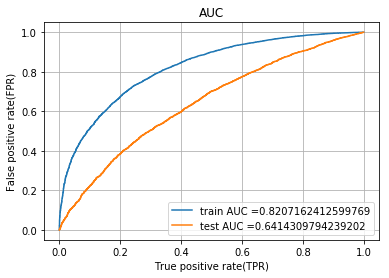

In [33]:
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=0.1, class_prior=[0.5,0.5], fit_prior=True)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True positive rate(TPR)")
plt.ylabel("False positive rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5509449154271203 for threshold 0.506
Train confusion matrix
[[ 2613   850]
 [ 5122 13860]]
Test confusion matrix
[[1322 1224]
 [4457 9497]]


In [36]:
#calculating top 10 features
#Concatinating all the features for set 1
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow,X_train_project_title_bow, X_train_prev_projects,X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_subject_categories_ohe,X_train_subject_subcategories_ohe,X_train_price_norm,X_train_quantity_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow,X_cv_project_title_bow, X_cv_state_ohe,X_cv_prev_projects, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_subject_categories_ohe,X_cv_subject_subcategories_ohe, X_cv_price_norm,X_cv_quantity_norm)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_project_title_bow, X_test_state_ohe,X_test_prev_projects, X_test_teacher_ohe, X_test_grade_ohe,X_test_subject_categories_ohe,X_test_subject_subcategories_ohe, X_test_price_norm,X_test_quantity_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

neigh = MultinomialNB(alpha=0.5, class_prior=[0.5,0.5], fit_prior=True)
neigh.fit(X_tr, y_train)

Final Data matrix
(22445, 7903) (22445,)
(11055, 7903) (11055,)
(16500, 7903) (16500,)


MultinomialNB(alpha=0.5, class_prior=[0.5, 0.5], fit_prior=True)

In [37]:
#To find top_10 feAtures
#collecting feature names for BOW set1

bow_features_names = []

for i in vectorizer_state.get_feature_names() :
    bow_features_names.append(i)

for i in vectorizer_teacher.get_feature_names() :
    bow_features_names.append(i)
    
for i in vectorizer_grade_category.get_feature_names() :
    bow_features_names.append(i)

for i in vectorizer_subject_category.get_feature_names() :
    bow_features_names.append(i)
    
for i in vectorizer_subject_sub_category.get_feature_names() :
    bow_features_names.append(i)

bow_features_names.extend(['price'])

bow_features_names.extend(['quantity'])

bow_features_names.extend(['prev_proposed_projects'])

for i in vectorizer_title.get_feature_names() :
    bow_features_names.append(i)
for i in vectorizer_essay.get_feature_names() :
    bow_features_names.append(i)

In [38]:
len(bow_features_names)

7903

In [39]:
pos_class_prob_sorted = neigh.feature_log_prob_[1, :].argsort()[::-1][:7903]
for i in pos_class_prob_sorted[0:10]:
    print(bow_features_names[i])

exposed
literature_writing_music
come in
because they are
we can
not
the table
and ready to
education teacher
differentiate


In [40]:
neg_class_prob_sorted = neigh.feature_log_prob_[0, :].argsort()[::-1][:7950]
for i in neg_class_prob_sorted[0:10]:
    print(bow_features_names[i])

exposed
literature_writing_music
come in
because they are
we can
not
the table
and ready to
education teacher
differentiate


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [41]:
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", " Test AUC"]

x.add_row(["BOW", "Naive Bayes", 0.8, 0.685])
x.add_row(["TFIDF", "Naive Bayes", 0.1, 0.641])

print(x)

+------------+-------------+-----------------+-----------+
| Vectorizer |    Model    | Hyper Parameter |  Test AUC |
+------------+-------------+-----------------+-----------+
|    BOW     | Naive Bayes |       0.8       |   0.685   |
|   TFIDF    | Naive Bayes |       0.1       |   0.641   |
+------------+-------------+-----------------+-----------+
